In [ ]:
"""
Palmetto Cluster Repo/Tutorial:
https://github.com/clemsonciti/palmetto-examples/tree/master/PyTorch

Slide deck:
https://docs.google.com/presentation/d/1feeIYRw7Gada3LGRgK5FOoxVqcEwRBf630KOcmS60J0/edit?usp=sharing

"""

'\nPalmetto Cluster Repo/Tutorial:\nhttps://github.com/clemsonciti/palmetto-examples/tree/master/PyTorch\n\nSlide deck:\nhttps://docs.google.com/presentation/d/1feeIYRw7Gada3LGRgK5FOoxVqcEwRBf630KOcmS60J0/edit?usp=sharing\n\n'

In [ ]:
import os
import torch
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset
from torchvision.io import ImageReadMode
from PIL import Image
import torchvision.transforms.functional as fn
import matplotlib.pyplot as plt
import pandas as pd
from torchvision.io import read_image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import cv2
from statistics import mean
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from tqdm import tqdm
from time import sleep
from torchsummary import summary
from google.colab import drive

In [ ]:
#connecting to google drive and connecting to GPU if available
#to use gpu (RAM/Disk dropdown > Change runtime type > Hardware Accelerator > GPU > Save)
drive.mount('/content/drive')
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


device(type='cuda')

In [ ]:
"""
copy data to local storage for faster loading (it is very important to do this)

**may take a few minutes to run
"""

## add your path to the bloodspot google drive here
# # hud:
# root_dir = '/content/drive/MyDrive/Watt_AI/Projects/Blood\ Spot/Data/blood_spot_fake_data_small/'
#noah:
root_dir = '/content/drive/MyDrive/Blood\ Spot/Data/blood_spot_fake_data_small/'


!cp -r $root_dir ./

In [ ]:
#only true if you ran the last cell
train_data_path = '/content/blood_spot_fake_data_small/train/'
test_data_path = '/content/blood_spot_fake_data_small/test/'

In [ ]:
"""
ExamObject class used in dataloader

For our data structure inside the dataloader we chose to do a list of ExamObjects and each ExamObject refers to a specific exam
Used this type of data structure for clarity and future proof/ease when this classifier is integrated into an app

In get_label you can change the number of bad spots that makes a bad card bad (Ex. if num bad > 1 then 2 bad spots means a bad card ...)
"""

class ExamObject():
  def __init__(self, exam_name):
    self.exam_name = exam_name
    self.dictionary = {'paths': []}

  def __repr__(self):
    return self.exam_name

  def add_path(self, path):
    self.dictionary['paths'].append(path)

  def get_paths(self):
    return self.dictionary['paths']

  def get_label(self):
    paths = self.dictionary['paths']
    num_bad = 0
    label = 0

    #check in the name of each spot in exam if named bad
    for path in paths:
      split = path.split('/')
      if 'bad' in split[-1].lower():
        num_bad += 1

    #if there is at least one bad spot then the whole card is bad
    """
    change num bad criteria here!
    """
    if num_bad > 0:
      label = 1
      
    return label

In [ ]:
"""
Dataloader which takes the base directiory of the data, a transforms function and size as parameters.

General Steps in the Dataloader:
__init__
1. construct variables passed into the function and also a list for the ExamObjects to be located
2. Walk through all image paths in the directory where the data is located and create the ExamObjects

(SIDE NOTE) Dataset directory should be in the following layout

              base directory 
              /             \
        train                 test
        |                       |
  exam1, exam2, ...         exam1, exam2, ...
        |                         |
5 spots in each exam         5 spots in each exam


__getitem__
1. Call the get_paths function on the ExamObject at the index passed.
2. read in each image from the paths, resize the image, and append it to an exam_tensor (exam_tensor is a list at that point, but is converted in next step)
3. Use torch.stack on exam_tensor and create a tensor of shape [5,3,255,255] (these correspond to: [number of spots, channels, length, width])
4. Apply transforms function on the exam_tensor
5. return the label for this exam using the get_label function from the ExamObject
"""

## labels: (1 is bad, 0 is good)
#pass tranforms fucntion & size parameter default 256

class BloodSpotDataset(Dataset):

  def __init__(self, data_path, transform=None, size= [255,255]):
    #base directory
    self.data_path = data_path
    self.size = size
    self.transform = transform
    self.exam_objects = []

    #loops through path given
    for root, _, files in os.walk(data_path, topdown=False):
      #checks that each card has 5 spots
      if len(files) != 5:
        continue
      
      #gets the name of the exam (exam1, exam2, ...) and assigns it to an exam object
      exam_name = root.split('/')[-1] 
      exam_object = ExamObject(exam_name)
      #loops through each spot in exam folder and adds it to the paths in the exam object instantiated above
      for path in files:
        exam_object.add_path(os.path.join(root,path))

      self.exam_objects.append(exam_object)


  def __len__(self):
    return len(self.exam_objects)
  
  def __getitem__(self, ix):
    #gets exam object
    exam_object = self.exam_objects[ix]
    #gets list of paths to the 5 individual spots from the exam object
    paths = exam_object.get_paths()
    
    #reads in image and resizes the image to size parameter
    exam_tensor = []
    for path in paths:
      img = read_image(path, mode = ImageReadMode.RGB)
      img = fn.resize(img, size=self.size)
      exam_tensor.append(img)
    
    #read and resize images from image path dictionary then stack the tensors into 4 dimensional tensor
    exam_tensor = torch.stack(exam_tensor)

    #transforms
    if self.transform:
      exam_tensor = self.transform(exam_tensor)

    #get labels
    label = exam_object.get_label()
    label = torch.Tensor([label]).type(torch.float)

    return label, exam_tensor

In [ ]:
#transformations
train_transform = transforms.Compose([
    transforms.ConvertImageDtype(torch.float32), #convert to float
    transforms.RandomPerspective(distortion_scale=0.2, p=0.4), #applies a persective transformation to 40% of images
    transforms.RandomRotation(360), #rotates images from 0-360°
    transforms.RandomApply(torch.nn.ModuleList([transforms.GaussianBlur(5, sigma=(0.1, 2.0))]), p=0.3),#applies a blur to 30% of images
    transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter(brightness=0.5, contrast=0.0, saturation=0.0, hue=0)]), p = 0.2), #applies a brightness effect on 20% of images
    transforms.Normalize(mean = [0.52621067, 0.5534213, 0.6714008], std = [0.2764587, 0.2725054, 0.18896917]) #normalizes images (necessary for training)
     ])

test_transform = transforms.Compose([
    transforms.ConvertImageDtype(torch.float32),
    transforms.Normalize(mean = [0.52621067, 0.5534213, 0.6714008], std = [0.2764587, 0.2725054, 0.18896917]) #values from individual spot classifier notebook
     ])

train_data = BloodSpotDataset(train_data_path, transform = train_transform)
test_data = BloodSpotDataset(test_data_path, transform = test_transform)

In [ ]:
print('label:  '+str(train_data[0][0]))
print('shape:  '+str(train_data[0][1].shape))
print('length of train_data: '+str(len(train_data)))
print('length of test_data: ' +str(len(test_data)))

label:  tensor([0.])
shape:  torch.Size([5, 3, 255, 255])
length of train_data: 300
length of test_data: 100


In [ ]:
#batch_size must be changed here
batch_size = 40

train_dataloader = torch.utils.data.DataLoader(dataset=train_data,
                                               batch_size=batch_size, 
                                               shuffle=True,
                                               num_workers=1)

test_dataloader = torch.utils.data.DataLoader(dataset=test_data,
                                               batch_size=batch_size, 
                                               shuffle=False,
                                               num_workers=1)

In [ ]:
train_labels, train_features = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([40, 5, 3, 255, 255])
Labels batch shape: torch.Size([40, 1])


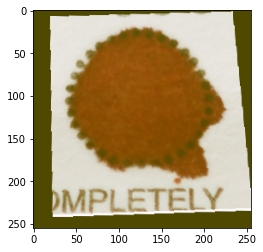

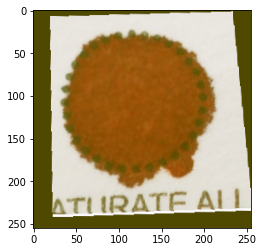

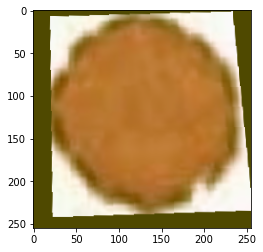

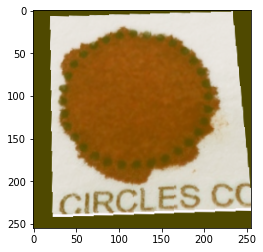

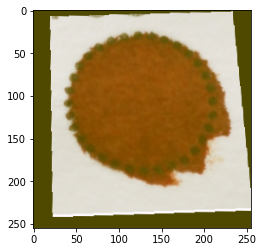

In [ ]:
# pictures of images to check transformations
img = train_features[7]
label = train_labels
for item in img:
  #rescale the image values from 0-1
  item = (item - item.min())/(item.max() - item.min())
  plt.imshow(item.permute(1, 2, 0))
  plt.show()

In [ ]:
#converting 5 probabilities into probability of one bad spot being in the card using equation below
#P(1 bad) = 1 - Πi5(1 - pi) 
def oneBad(x):

  x = (-1*x)+1
  x = torch.prod(x, dim=1)
  x = 1-x

  return x

#converting 5 probabilities into probability of two bads spot being in the card using equation below
#P(2) = 1 - Πi^5( 1 - pi) - Σi^5 (pi) * Πj≠i^4(1 - pj)
#uses matrix math so it can be used in training
def twoBad(x):

  batch_size = x.shape[0]
  prob = oneBad(x)

  mat = (1-x)[:,None].expand(batch_size,5,5)

  a_diags = torch.diagonal(mat, dim1=-2, dim2=-1).diag_embed()
  eye_diags = torch.ones_like(x).diag_embed()
  mat = mat - a_diags + eye_diags

  r = mat.prod(dim=-1)

  prob = prob - (x*r).sum(dim=-1)

  return prob

In [ ]:
#Convolution class for cleanliness in Neural Net
"""
Idea for the neural network is to use the equations above to predict whether a card is bad given individual spot probabilities
more explained in the slide deck for blood-spot project


  steps in individidual spot network (Net)
  1. apply three ConvBlock operations to the input images using the ConvBlock Class
    Steps for the ConvBlock operations
    1. apply 2d convolution
    2. apply batch normalization
    3. apply Relu activation function unless otherwise passed when instantiating the object
    4. apply dropout
    5. apply maxpooling

  2. flatten the images

  3. apply a fully connected layer

  steps in the FiveToOneNetwork
  1. 
"""

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dropout_rate=0.1, activation_func = nn.ReLU):
        super(ConvBlock, self).__init__()

        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size),
            nn.BatchNorm2d(out_channels),
            activation_func(),
            nn.Dropout(dropout_rate),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        return self.block(x)

class Net(nn.Module):

    def __init__(self): # sequential 

        super(Net, self).__init__()


        self.operation1 = ConvBlock(3,5,3,0.1)
        self.operation2 = ConvBlock(5,10,3,0.1)
        # Tanh function used on last convolution to allow negative outputs
        self.operation3 = ConvBlock(10,10,3,0.1, activation_func = nn.Tanh)

        #linear layer
        self.fc1 = nn.Linear(10 * 30 * 30, 1)

    def forward(self, x):

        x = self.operation1(x)
        x = self.operation2(x)
        x = self.operation3(x)

        # flatten all dimensions except the batch dimension
        x = torch.flatten(x, 1) 
        
        #fully connected layer
        x = self.fc1(x)

        return x


class FiveToOneNetwork(nn.Module):

    def __init__(self, net: Net, freeze_net: bool = True): # sequential 
      super(FiveToOneNetwork, self).__init__()
      self.image_network = net

      #loops through parameters in inidividual spot classifier and turns off learning if freeze_net=True
      if freeze_net:
        for p in self.image_network.parameters():
          p.requires_grad = False
      

      self.sigmoid = nn.Sigmoid()

    def forward(self, x):

      batch_size = x.shape[0]

      # change view
      x = x.view([5*batch_size,3,255,255])

      #get probabilities for each spot
      x = self.image_network(x)

      #change view back
      x = x.view([batch_size,5])

      #apply sigmoid to get probabilities
      x = self.sigmoid(x)

      #apply function to consolidate probabilities into one probability for the card
      x = oneBad(x)

      return x


In [ ]:
#defining the networks, load weights for individual spot network, and send to device.
net = Net()
net.load_state_dict(torch.load('/content/model1'))
net2 = FiveToOneNetwork(net, freeze_net = True)
net = net.to(device)
net2 = net2.to(device)


In [ ]:
"""
train and test loop functions
"""

def train(model, device, train_loader, optimizer, epoch, criterion):
    #set model to train mode
    model.train()
    train_loss = 0

    #progress bar
    with tqdm(train_loader, unit="batch") as tepoch:
      for batch_idx, (target, data) in enumerate(tepoch):
        tepoch.set_description(f"Epoch {epoch}")
        
        #changing view
        target = target.view([target.shape[0]])
        #send to device
        data, target = data.to(device), target.to(device)
        #get output from model
        output = model(data)
        #calculate loss
        loss = criterion(output, target.float())
        #zero gradients
        optimizer.zero_grad()
        #backpropagation
        loss.backward()
        #take step down
        optimizer.step()
        #add to loss
        train_loss += loss.item()
        #progress bar
        tepoch.set_postfix(loss=loss.item())
        sleep(0.1)

    #average losss
    train_loss /= len(train_loader.sampler)

    return train_loss

def test(model, device, test_loader, criterion):
    #set model to eval mode
    model.eval()
    #used for average loss and accuracy
    test_loss = 0
    correct = 0

    #turning off gradients
    with torch.no_grad():
      for target, data in test_loader:
        #change view
        target = target.view([target.shape[0]])

        data, target = data.to(device), target.to(device)

        #uses the small nn to consolidate weights into indidual score for each card
        output = model(data)
        
        #change probabilities to zero or one by rounding
        pred = (output>.5).type(torch.int)
        target = target.type(torch.int)
        
        #calculating test loss
        loss = criterion(output, target.float()) 

        # sum up batch loss
        test_loss += loss.item()
        
        #calculate number of correct outputs
        correct += pred.eq(target).sum().item()#

      test_loss /= len(test_loader.sampler)

      print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
          test_loss, correct, len(test_loader.dataset),
          100. * correct / len(test_loader.dataset)))
    
    return test_loss

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net2.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
#train and test loss curve
train_loss = []
test_loss = []

In [ ]:
for epoch in range(3):
    train_loss.append(train(net2, device, train_dataloader, optimizer, epoch, criterion))
    test_loss.append(test(net2, device, test_dataloader, criterion))
    scheduler.step()

print('Finished Training')

Test set: Average loss: 0.0161, Accuracy: 92/100 (92.00%)


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Test set: Average loss: 0.0161, Accuracy: 92/100 (92.00%)
Test set: Average loss: 0.0161, Accuracy: 92/100 (92.00%)
Finished Training


In [ ]:
"""
Getting Metrics Below
...
"""

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

#setting batch_size to full test dataset for more accuracy
stats_loader = torch.utils.data.DataLoader(dataset=test_data,
                                               batch_size=len(test_data),
                                               shuffle=True,
                                               num_workers=1)
#getting the batch
targets, test_features = next(iter(stats_loader))
#getting preds from trained model
#sending features to gpu because model is there
preds = net2(test_features.to(device))
#detaching from gpu
preds = preds.cpu().detach()
#thresholding the preds at .5 then convert to numpy array
preds = (preds>.5).type(torch.int).numpy()
#targets are lists of lists so I flatten and cast to int
targets = np.array(targets).flatten().astype(int)
#computing accuracy
correct = 0
for i, pred in enumerate(preds):
  if pred == targets[i]:
    correct += 1
accuracy = correct / len(preds)

#getting scores using sklearn functions
fpr, tpr, thresholds = roc_curve(targets, preds)
auc_score = roc_auc_score(targets, preds, average='macro')
precision = precision_score(targets,preds, average='macro')
recall = recall_score(targets,preds, average='macro')

print("accuracy: "+str(round(accuracy,4)))
print("precision: "+str(round(precision,4)))
print("recall: "+ str(round(recall,4)))
print("auc_roc score: "+str(round(auc_score,4)))

accuracy: 0.92
precision: 0.931
recall: 0.92
auc_roc score: 0.92


No handles with labels found to put in legend.


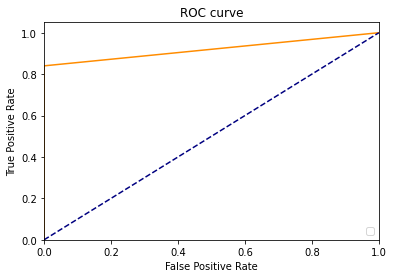

AUC score:0.9199999999999999


In [ ]:
plt.figure()
plt.plot(
    fpr,
    tpr,
    color="darkorange"
)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.show()
print("AUC score:"+str(auc_score))
# print("F1 score:"+str(f1_score))

In [ ]:
print(test_loss)

[0.016140410602092745, 0.016140410602092745, 0.016140410602092745]


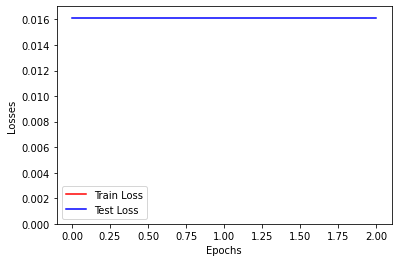

In [ ]:
plt.plot(train_loss, color = 'r', label='train loss')
plt.plot(test_loss, color = 'b', label='test loss')
plt.ylim(0,)
plt.ylabel("Losses")
plt.xlabel("Epochs")
plt.legend(['Train Loss', 'Test Loss'])
plt.show()